In [1]:
import io

import matplotlib.pyplot as plt
import numpy as np
import histomicstk as htk

from histomicstk.segmentation.label import trace_object_boundaries
from histomicstk.utils import merge_colinear

from skimage.data import astronaut
from skimage.measure import regionprops
from skimage.measure import regionprops_table
from skimage.segmentation import slic
from skimage.segmentation import mark_boundaries
from skimage.util import img_as_float
from skimage.io import imread

import SimpleITK as sitk

# Defeat ITK lazy loading so that loading does not affect timings of SLIC algorithm.
import itkConfig
itkConfig.LazyLoading=False
import itk

from fast_slic import Slic

import time

In [2]:
# We use itk2nestedlist to convert an ITK vertex list to an ordinary Python list of lists,
# but it can be used in similar situations as well.
def itk2nestedlist(inp):
    if hasattr(inp, "Size") and hasattr(inp, "GetElement"):
        response = []
        for i in range(inp.Size()):
            response.append(itk2nestedlist(inp.GetElement(i)))
        return response
    else:
        return inp


# trace_object_boundaries2 replaces and is much faster than
# histomicstk.segmentation.label.trace_object_boundaries.
# However, trace_object_boundaries2 currently ignores conn, x_start, y_start, and max_length.
def trace_object_boundaries2(im_label,
                             conn=4, trace_all=False,
                             x_start=None, y_start=None,
                             max_length=None,
                             simplify_colinear_spurs=True,
                             eps_colinear_area=0.01):
    """Performs exterior boundary tracing of one or more objects in a label
    mask. If a starting point is not provided then a raster scan will be performed
    to identify the starting pixel.

    Parameters
    ----------
    im_label : array_like
        A binary mask image.
    conn : int
        Neighborhood connectivity to evaluate. Valid values are 4 or 8.
        Default value = 4.
    trace_all : bool
        Specify True if you want to trace boundaries of all objects.
        Default = False
    x_start : int
        Starting horizontal coordinate to begin tracing. Default value = None.
    y_start : int
        Starting vertical coordinate to begin tracing. Default value = None.
    max_length : int
        Maximum boundary length to trace before terminating. Default value =
        None.
    simplify_colinear_spurs : bool
        If True colinear streaks/spurs in the object boundary will be
        simplified/removed. Note that if the object boundary is entirely
        colinear then the object itself will be removed. Default = True
    eps_colinear_area : int
        Minimum area of triangle formed by three consecutive points on the
        contour for them to be considered ContourExtractor2DImageFilteras non-colinear. Default value =
        0.01.

    Notes
    -----
    The Improved Simple Boundary Follower (ISBF) from the reference below is
    used for 4-connected tracing. This algorithm provides accurate tracing with
    competitive execution times. 8-connected tracing is implemented using the
    Moore tracing algorithm.

    Returns
    -------
    X : array_like
        A set of 1D array of horizontal coordinates of contour seed pixels for
        tracing.
    Y : array_like
        A set of 1D array of the vertical coordinates of seed pixels for
        tracing.

    References
    ----------
    .. [#] J. Seo et al "Fast Contour-Tracing Algorithm Based on a Pixel-
       Following Method for Image Sensors" in Sensors,vol.16,no.353,
       doi:10.3390/s16030353, 2016.

    """

    assert trace_all == True
    assert simplify_colinear_spurs == True
    assert x_start is None
    assert y_start is None
    assert max_length is None
 
    X = []
    Y = []

    rprops = regionprops(im_label)
    numLabels = len(rprops)

    for i in range(numLabels):

        # get bounds of label mask
        min_row, min_col, max_row, max_col = rprops[i].bbox

        mrows = max_row - min_row + 2
        mcols = max_col - min_col + 2

        # grab label mask
        mask = np.zeros((mrows, mcols))
        mask[1:mrows-1, 1:mcols-1] = (
            im_label[
                min_row:max_row, min_col:max_col
            ] == rprops[i].label
        ).astype(bool)

        polylineparametricpaths = itk.contour_extractor2_d_image_filter(itk.GetImageFromArray((2*mask).astype(np.uint8)), contour_value=1)
        if not isinstance(polylineparametricpaths, tuple):
            polylineparametricpaths = (polylineparametricpaths,)
        for polylineparametricpath in polylineparametricpaths:
            vertices = polylineparametricpath.GetVertexList()
            vertices = itk2nestedlist(vertices)
            by, bx = np.transpose(np.array(vertices))

            if len(bx) > 0:
                bx = bx + (min_row - 1)
                by = by + (min_col - 1)
                X.append(bx)
                Y.append(by)

    return X, Y


# trace_object_boundaries3 replaces and is much faster than
# histomicstk.segmentation.label.trace_object_boundaries.
# It uses the new values_are_labels functionality of itk.contour_extractor2_d_image_filter.
# However, trace_object_boundaries3 currently ignores conn, x_start, y_start, and max_length.
def trace_object_boundaries3(im_label,
                             conn=4, trace_all=False,
                             x_start=None, y_start=None,
                             max_length=None,
                             simplify_colinear_spurs=True,
                             eps_colinear_area=0.01):
    """Performs exterior boundary tracing of one or more objects in a label
    mask. If a starting point is not provided then a raster scan will be performed
    to identify the starting pixel.

    Parameters
    ----------
    im_label : array_like
        A binary mask image.
    conn : int
        Neighborhood connectivity to evaluate. Valid values are 4 or 8.
        Default value = 4.
    trace_all : bool
        Specify True if you want to trace boundaries of all objects.
        Default = False
    x_start : int
        Starting horizontal coordinate to begin tracing. Default value = None.
    y_start : int
        Starting vertical coordinate to begin tracing. Default value = None.
    max_length : int
        Maximum boundary length to trace before terminating. Default value =
        None.
    simplify_colinear_spurs : bool
        If True colinear streaks/spurs in the object boundary will be
        simplified/removed. Note that if the object boundary is entirely
        colinear then the object itself will be removed. Default = True
    eps_colinear_area : int
        Minimum area of triangle formed by three consecutive points on the
        contour for them to be considered ContourExtractor2DImageFilteras non-colinear. Default value =
        0.01.

    Notes
    -----
    The Improved Simple Boundary Follower (ISBF) from the reference below is
    used for 4-connected tracing. This algorithm provides accurate tracing with
    competitive execution times. 8-connected tracing is implemented using the
    Moore tracing algorithm.

    Returns
    -------
    X : array_like
        A set of 1D array of horizontal coordinates of contour seed pixels for
        tracing.
    Y : array_like
        A set of 1D array of the vertical coordinates of seed pixels for
        tracing.

    References
    ----------
    .. [#] J. Seo et al "Fast Contour-Tracing Algorithm Based on a Pixel-
       Following Method for Image Sensors" in Sensors,vol.16,no.353,
       doi:10.3390/s16030353, 2016.

    """

    assert trace_all == True
    assert simplify_colinear_spurs == True
    assert x_start is None
    assert y_start is None
    assert max_length is None
 
    X = []
    Y = []

    polylineparametricpaths = itk.contour_extractor2_d_image_filter(itk.image_from_array(im_label.astype(np.float32)), label_contours=True)
    if not isinstance(polylineparametricpaths, tuple):
        polylineparametricpaths = (polylineparametricpaths,)
    for polylineparametricpath in polylineparametricpaths:
        vertices = polylineparametricpath.GetVertexList()
        vertices = itk2nestedlist(vertices)
        by, bx = np.transpose(np.array(vertices))

        if len(bx) > 0:
            X.append(bx)
            Y.append(by)

    return X, Y


# plotit() computes superpixel boundaries using the supplied trace_object_boundaries_function and then
# displays the image, the superpixel centroids, and the superpixel boundaries.
def plotit(countFigure, img, label, trace_object_boundaries_function):
    start = time.time()
    Y, X = trace_object_boundaries_function(label, conn=4, trace_all=True,
                                            simplify_colinear_spurs=True,
                                            eps_colinear_area=0.01)
    print(f'#boundary paths = {len(X)}')
    X, Y = zip(*[merge_colinear(x,y) for x,y in zip(X,Y)])
    print('Tracing time elapsed: {}'.format(time.time()-start))

    #get superpixel centroids
    centroids = regionprops_table(label, properties=['centroid'])
    cY = centroids['centroid-0']
    cX = centroids['centroid-1']
    
    fig, ax = plt.subplots(num=countFigure)
    ax.imshow(img)
    fig.gca().set_axis_off()
    fig.tight_layout()
    # ax.scatter(cX, cY)
    for x,y in zip(X, Y):
        ax.plot(x, y)


In [3]:
if True:
    # img = imread('https://data.kitware.com/api/v1/file/57718cc48d777f1ecd8a883f/download')[...,:3]
    # img = imread('https://data.kitware.com/api/v1/file/57718cc48d777f1ecd8a883f/download')[0:1000,0:1000,:3]
    # img = imread('https://data.kitware.com/api/v1/file/576ad39b8d777f1ecd6702f2/download')[...,:3]
    img = imread('https://data.kitware.com/api/v1/file/576ad39b8d777f1ecd6702f2/download')[0:400,0:400,:3]
else:
    img = img_as_float(astronaut()[::2, ::2])

# Tile multiple copies of the image to give this test more to work with.
# img = np.tile(img, (1,2,1))
# img = np.tile(img, (8,8,1))
# img = np.tile(img, (16,16,1))

# Time the SLIC calculation for each approach.
# We do not time the conversion between data formats because the production level code will
# use the optimal format throughout rather than switching back and forth.

#skimage
start = time.time()
label1 = slic(img, n_segments=int(img.shape[0]*img.shape[1]/(64.0*64.0)), compactness=1, sigma=1, start_label=1)
print('skimage SLIC time elapsed: %s ' % format(time.time()-start))

#Simple ITK
imgSITK = sitk.GetImageFromArray(img, isVector=True)
start = time.time()
labelSITK = sitk.SLIC(imgSITK, spatialProximityWeight=10.0/256.0, superGridSize=(64,64))
print('SITK SLIC time elapsed: %s ' % format(time.time()-start))
label2 = sitk.GetArrayFromImage(labelSITK)

#ITK
imgITK = itk.image_from_array(img.astype(np.float32), is_vector=True)
start = time.time()
labelITK = itk.slic_image_filter(imgITK, SpatialProximityWeight=10.0/256.0, SuperGridSize=(64,64)
#                                , ttype=(itk.Image[itk.Vector[itk.F,3],2], itk.Image[itk.UL,2])
                                )
print('ITK SLIC time elapsed: %s ' % format(time.time()-start))
label3 = itk.array_from_image(labelITK)

#fast_slic
algFastSLIC = Slic(num_components=int(img.shape[0]*img.shape[1]/(64.0*64.0)), compactness=1)
imgFastSLIC = (img*256).astype(np.uint8)
start = time.time()
label4 = algFastSLIC.iterate(imgFastSLIC)
print('fast_slic time elapsed: %s ' % format(time.time()-start))

skimage SLIC time elapsed: 0.23926854133605957 
SITK SLIC time elapsed: 0.09080147743225098 
ITK SLIC time elapsed: 0.10226058959960938 
fast_slic time elapsed: 0.06587004661560059 


#boundary paths = 10
Tracing time elapsed: 0.1613776683807373
#boundary paths = 12
Tracing time elapsed: 0.048757314682006836
#boundary paths = 12
Tracing time elapsed: 0.06569361686706543
#boundary paths = 35
Tracing time elapsed: 0.38594722747802734
#boundary paths = 40
Tracing time elapsed: 0.1004188060760498
#boundary paths = 41
Tracing time elapsed: 0.09275627136230469
#boundary paths = 69
Tracing time elapsed: 0.5447225570678711
#boundary paths = 72
Tracing time elapsed: 0.13214516639709473
#boundary paths = 73
Tracing time elapsed: 0.11176085472106934
#boundary paths = 38
Tracing time elapsed: 0.2462155818939209
#boundary paths = 38
Tracing time elapsed: 0.062047481536865234
#boundary paths = 39
Tracing time elapsed: 0.05953049659729004


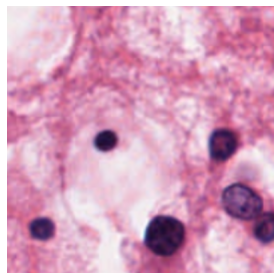

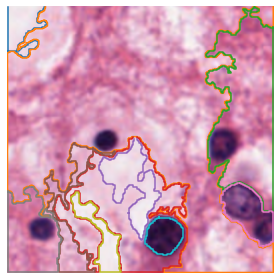

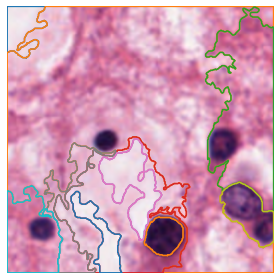

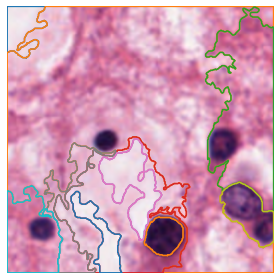

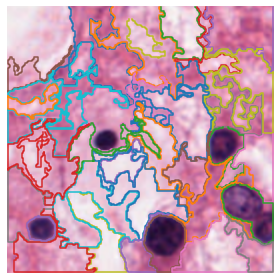

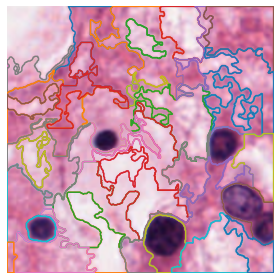

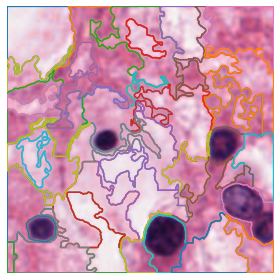

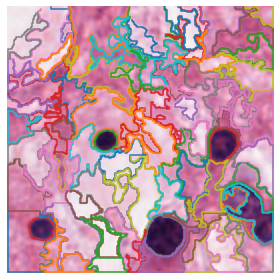

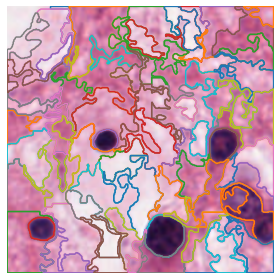

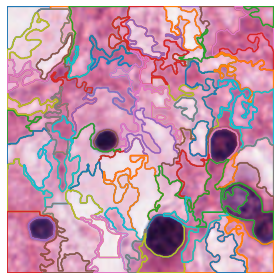

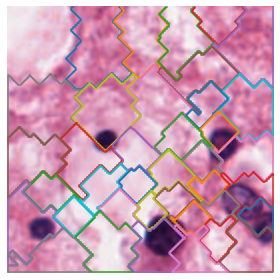

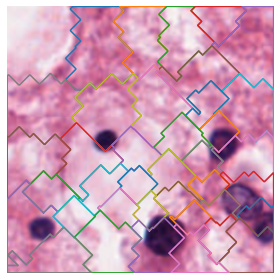

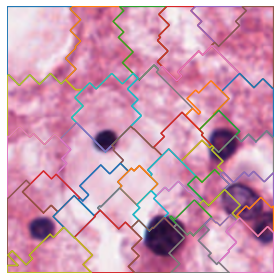

In [4]:
# Show the tiled input image we have been operating on
countFigure = 0
fig, ax = plt.subplots(num=countFigure)
fig.gca().set_axis_off()
fig.tight_layout()
ax.imshow(img)
plt.savefig("HnE0.png")
countFigure = countFigure + 1

# We will show the tracings that we get using trace_object_boundaries2, defined above, for each of the SLIC algorithms.
# Should we also show the tracings that we get using histomicstk.segmentation.label.trace_object_boundaries?
show_slow = True

if show_slow:
    plotit(countFigure, img, label1, trace_object_boundaries)
    countFigure = countFigure + 1
plotit(countFigure, img, label1, trace_object_boundaries2)
countFigure = countFigure + 1
plotit(countFigure, img, label1, trace_object_boundaries3)
countFigure = countFigure + 1
if show_slow:
    plotit(countFigure, img, label2, trace_object_boundaries)
    countFigure = countFigure + 1
plotit(countFigure, img, label2, trace_object_boundaries2)
countFigure = countFigure + 1
plotit(countFigure, img, label2, trace_object_boundaries3)
countFigure = countFigure + 1
if show_slow:
    plotit(countFigure, img, label3, trace_object_boundaries)
    countFigure = countFigure + 1
plotit(countFigure, img, label3, trace_object_boundaries2)
countFigure = countFigure + 1
plotit(countFigure, img, label3, trace_object_boundaries3)
plt.savefig('HnE1.png')
countFigure = countFigure + 1
if show_slow:
    plotit(countFigure, img, label4, trace_object_boundaries)
    countFigure = countFigure + 1
plotit(countFigure, img, label4, trace_object_boundaries2)
countFigure = countFigure + 1
plotit(countFigure, img, label4, trace_object_boundaries3)
plt.savefig('HnE2.png')
countFigure = countFigure + 1